In [0]:
"""
Q4. Compare convergence for various gradient descent algorithm. 

Comparison :
Gradient descent : Gradient descent with fixed step size does not convege fast due to fixed learning rate. So we need to try different
 learning rates to get better convergence.

Armijo line search : This adds a line search logic to update the learning rate based on our progress. It works better than the gradient
descent algorithm.

Accelerated gradient descent : It uses extrapolation to get better estimate of alpha. Combined with line search it works really well 
and converges really fast.

Conjugate gradient descent : Conjugate gradient descent uses newton approximation to move near to the optimal solution. It works better
than armijo line search and comparable to accelerated gradient descent. Used fletcher reeves variant for the update beta.

Barzilai gradient descent : Barzilai Borwein used alpha update formula to reset alpha in every iteration. It works better
than armijo line search and comparable to accelerated gradient descent and conjugate gradient descent. Used fletcher reeves variant for the update beta.
"""
from scipy.io import loadmat
import math 
import pandas as pd
import numpy as np

def logisticLoss(w, X, y, lam):
    m = X.shape[0]
    Xw = np.matmul(X, w)

    loss = np.sum(np.log(1 + np.exp(-1 * y * (Xw))))
    loss += lam * (np.linalg.norm(w) ** 2)

    grad = np.zeros(w.shape)
    cc = np.array(-1 * y * (Xw), dtype=np.float128)
    nexp = np.exp(cc)
    grad = (-1) * np.matmul(X.T, y * nexp / (1 + nexp))
    grad += 2 * lam * w
    return loss, grad

def hingeLoss(w, X, y, lam):
  m = X.shape[0]
  Xw = X.dot(w)
  tmp = (1 - 1* y * Xw)
  idx = np.where(tmp > 0)
  loss = np.sum(tmp[idx])
  loss += lam*(np.linalg.norm(w)**2)

  grad = np.zeros(w.shape)
  rows = X.shape[0]
  cols = X.shape[1]
  grad = np.sum(np.where(np.repeat((1 - y*np.matmul(X, w)), cols).reshape(rows, cols) > 0, 
                         (-1)*np.multiply(np.repeat(y, cols).reshape(rows, cols), 
                                          X), 0), axis = 0)

  grad = 2*lam*w + grad
  return loss, grad

def gd(funObj, w, maxEvals, alpha, X, y, lam, verbosity):
    [f,g] = funObj(np.array(w), np.array(X), np.array(y), lam)
    funEvals = 1
    funVals = []

    while (1):
        w = w - alpha*g
        [f,g] = funObj(np.array(w), np.array(X), np.array(y), lam)
        optCond = np.linalg.norm(g, np.inf)

        if verbosity > 0:
            print(funEvals, alpha, f, optCond)

        
        funEvals = funEvals + 1
        funVals.append(f)
        if (optCond < 0.001) or (funEvals > maxEvals):
            break

    return funVals

def gd_with_line_searchv4(funObj, w, maxEvals, alpha, X, y, lam, gamma, verbosity):
    [f,g] = funObj(np.array(w), np.array(X), np.array(y), lam)
    funEvals = 1
    funVals = []
    f_old = f
    if alpha == 0:
      alpha = 1.0/np.linalg.norm(g, np.inf)
    
    while (1):
        wp = w - alpha * g
        [fp, gp] = funObj(np.array(wp), np.array(X), np.array(y), lam)
        funEvals = funEvals + 1
        funVals.append(fp)
        optCond = np.linalg.norm(gp, np.inf)
        if verbosity > 0:
            print(funEvals, alpha, fp, optCond)
        if funEvals > maxEvals:
            break

        gTg = np.dot(g.T, g)
            
        while fp > f - gamma * alpha * gTg:
            alpha = (alpha * alpha * gTg)/(2*(fp + alpha * gTg - f))
            if alpha > 3 or alpha < 1e-6:
              alpha = 1.0/np.linalg.norm(g, np.inf)
            wp = w - alpha * g
            [fp, gp] = funObj(np.array(wp), np.array(X), np.array(y), lam)
            #funEvals = funEvals + 1
            #optCond = np.linalg.norm(gp, np.inf)
            #funVals.append(fp)
            #if verbosity > 0:
            #  print(funEvals, alpha, fp, optCond)
            #if funEvals > maxEvals:
            #  break

        f_old = f
        f = fp
        g = gp
        w = wp
        alpha = min(1, (2.0 * (f_old - f)) / gTg)
        if alpha > 3 or alpha < 1e-6:
          alpha = 1.0/np.linalg.norm(g, np.inf)
        
        optCond = np.linalg.norm(g, np.inf)

        if (optCond < 0.001) or (funEvals > maxEvals):
            break

    return funVals

def accelerated_gradient_descent(funObj, w, maxEvals, alpha, X, y, lam, gamma, verbosity):
    [f,g] = funObj(np.array(w), np.array(X), np.array(y), lam)
    funEvals = 1
    funVals = []
    f_old = f
    t = 1
    if alpha == 0:
      alpha = 1.0/np.linalg.norm(g, np.inf)
    w_old = 0
    yy = w
    while (1):
        if funEvals > 1:
            tp = (1.0 + math.sqrt(1 + 4 * t * t))/2.0
            yy = w + ((t-1)/tp)*(w - w_old)
            t = tp
            [f, g] = funObj(np.array(yy), np.array(X), np.array(y), lam)
            funEvals = funEvals + 1
            funVals.append(f)
            optCond = np.linalg.norm(g, np.inf)
            if verbosity > 0:
              print(funEvals, alpha, f, optCond)
            if funEvals > maxEvals:
              break

        w_old = w
        wp = yy - alpha * g
        [fp, gp] = funObj(np.array(wp), np.array(X), np.array(y), lam)
        funEvals = funEvals + 1
        funVals.append(fp)
        optCond = np.linalg.norm(gp, np.inf)
        if verbosity > 0:
            print(funEvals, alpha, fp, optCond)
        if funEvals > maxEvals:
            break
        gTg = np.dot(g.T, g)
        while fp > f - gamma * alpha * gTg:
            alpha = (alpha * alpha * gTg)/(2*(fp + alpha * gTg - f))
            if alpha > 2 or alpha < 1e-6:
              alpha = 1.0/np.linalg.norm(g, np.inf)
            wp = yy - alpha * g
            [fp, gp] = funObj(np.array(wp), np.array(X), np.array(y), lam)
            #funEvals = funEvals + 1
            #funVals.append(fp)
            #optCond = np.linalg.norm(gp, np.inf)
            #if verbosity > 0:
            #  print(funEvals, alpha, fp, optCond)
            #if funEvals > maxEvals:
            #  break

        f_old = f
        f = fp
        #g = gp
        w = wp
        alpha = min(1, (2.0 * (f_old - f)) / gTg)
        if alpha > 2 or alpha < 1e-6:
              alpha = 1.0/np.linalg.norm(g, np.inf)
        
        optCond = np.linalg.norm(g, np.inf)

        if (optCond < 0.001) or (funEvals > maxEvals):
            break

    return funVals

# Conjugate Gradient Descent
def conjugate_gd(funObj, w, maxEval, alpha, X, y, lam, gamma, verbosity):
  [fo,go] = funObj(np.array(w),np.array(X),np.array(y),lam)
  funEvals = 1
  funVals = []
  dcurr = -go
  gprev = np.linalg.norm(go)**2
  alpha = 1/np.linalg.norm(go)
  while(1):
    [f,g] = funObj(np.array(w),np.array(X),np.array(y),lam)
    optCond = np.linalg.norm(g, np.inf)
    if verbosity > 0:
      print(funEvals, alpha, f, optCond)
    wp = w + alpha*dcurr
    [fp,gp] = funObj(np.array(wp),np.array(X),np.array(y),lam)
    while (fp > f - gamma*alpha*(np.linalg.norm(g))):
      num = alpha**2 *((np.dot(g.T,g)).item())
      den = fp + alpha*(np.dot(g.T,g).item()) - f
      alpha = num /(2*den)
      #if alpha > 3 or alpha <= 1e-6:
      #  alpha = 1/np.linalg.norm(go)
      wp = w + alpha*dcurr
      [fp,gp] = funObj(np.array(wp),np.array(X),np.array(y),lam)
    
    alpha = min(1,2*(f - fp)/np.dot(g.T,g))
    if alpha > 2 or alpha <= 1e-6:
      alpha = 1/np.linalg.norm(go)
    gcurr = np.linalg.norm(g)**2
    beta = float(gcurr*1.0)/float(gprev)
    dn = -g + beta*dcurr
    gprev = gcurr
    dcurr = dn
    f = fp
    w = wp
    funEvals = funEvals + 1
    funVals.append(f)
    if((optCond < 1e-3) or (funEvals > maxEval)):
      break
    
  return funVals

def conjugate_gradient_descent_deprecated(funObj, w, maxEvals, alpha, X, y, lam, gamma, verbosity):
    [f, g] = funObj(np.array(w), np.array(X), np.array(y), lam)
    funEvals = 1
    funVals = []
    f_old = f
    d = -g
    deltanew = np.dot(g.T, g)
    delta0 = deltanew
    if alpha == 0:
      alpha = 1.0 / np.linalg.norm(g, np.inf)

    while (1):
        wp = w + alpha * d
        [fp, gp] = funObj(np.array(wp), np.array(X), np.array(y), lam)
        funVals.append(fp)
        funEvals = funEvals + 1
        optCond = np.linalg.norm(gp, np.inf)
        if verbosity > 0:
            print(funEvals, alpha, fp, optCond)

        if funEvals > maxEvals:
            break
        gTg = np.dot(g.T, g)
        while fp > f - gamma * alpha * gTg:
            alpha = (alpha * alpha * gTg) / (2 * (fp + alpha * gTg - f))
            if alpha > 2 or alpha < 1e-6:
              alpha = 1.0/np.linalg.norm(g, np.inf)
            wp = w + alpha * g
            [fp, gp] = funObj(np.array(wp), np.array(X), np.array(y), lam)
            #funVals.append(fp)
            #funEvals = funEvals + 1
            #optCond = np.linalg.norm(gp, np.inf)
            #if verbosity > 0:
            #  print(funEvals, alpha, fp, optCond)
            #if funEvals > maxEvals:
            #  break

        f_old = f
        f = fp
        g = gp
        w = wp
        alpha = min(1, (2.0 * (f_old - f)) / gTg)
        if alpha > 2 or alpha < 1e-6:
          alpha = 1.0/np.linalg.norm(g, np.inf)
        
        deltaold = deltanew
        deltanew = np.dot(g.T, g)
        beta = float(deltanew*1.0 / float(deltaold))
        d = -g + beta*d
        optCond = np.linalg.norm(g, np.inf)

        if (optCond < 0.001) or (funEvals > maxEvals):
            break

    return funVals

def barzilai_borwein(funObj, w, maxEvals, alpha, X, y, lam, gamma, verbosity):
    [f,g] = funObj(np.array(w), np.array(X), np.array(y), lam)
    funEvals = 1
    funVals = []
    f_old = f
    #t = 1
    if alpha == 0:
        alpha = 1.0/np.linalg.norm(g, np.inf)
    #g_old = g
    w_old = w
    while (1):
        if funEvals > 1:
            g_diff = g - g_old
            w_diff = w - w_old
            alpha = np.asscalar((np.dot(w_diff.T, w_diff)*1.0)/(np.dot(w_diff.T, g_diff)))
            if alpha > 2 or alpha < 1e-6:
              alpha = 1.0/np.linalg.norm(g, np.inf)
        d = g
        wp = w - alpha * d
        [fp, gp] = funObj(np.array(wp), np.array(X), np.array(y), lam)
        funVals.append(fp)
        optCond = np.linalg.norm(gp, np.inf)
        if verbosity > 0:
            print(funEvals, alpha, fp, optCond)
        funEvals = funEvals + 1
        if funEvals > maxEvals:
            break
        gTg = np.dot(g.T, d)
        while fp > f - gamma * alpha * gTg:
            alpha = (alpha * alpha * gTg)/(2*(fp + alpha * gTg - f))
            if alpha > 2 or alpha < 1e-6:
              alpha = 1.0/np.linalg.norm(g, np.inf)
            wp = w - alpha * d
            [fp, gp] = funObj(np.array(wp), np.array(X), np.array(y), lam)
            #funEvals = funEvals + 1
            #funVals.append(fp)
            #optCond = np.linalg.norm(gp, np.inf)
            #if verbosity > 0:
            #  print(funEvals, alpha, fp, optCond)
            #if funEvals > maxEvals:
            #  break
        g_old = g
        f_old = f
        w_old = w
        f = fp
        g = gp
        w = wp
        
        #alpha = min(1, (2.0 * (f_old - f)) / gTg)
        #f_old = f
        optCond = np.linalg.norm(g, np.inf)

        if (optCond < 0.001) or (funEvals > maxEvals):
            break

    return funVals



In [38]:
"""
Running gradient descent algorithms for logistic loss
"""
X = loadmat(r"train.mat")
y = np.loadtxt(r"train.targets")
X = X['X'].todense()
w = np.random.random(X.shape[1])
y = np.array(y)
X_main = X
Y_main = y

num_iterations = 250
gamma = 0.0001
verbosity = 1
gd_alpha = 0.00001
gd_with_ls_alpha = 0
lam = 0.01


print("Running gradient descent algorithms for logistic loss")
print("Running normal gradient descent")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funV1 = gd(logisticLoss, w, num_iterations, gd_alpha, X, y, lam, verbosity)

print("Running gradient descent with armijo backtracking line search")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funV2 = gd_with_line_searchv4(logisticLoss, w, num_iterations, gd_with_ls_alpha, X, y, lam, gamma, verbosity)

print("Running accelerated gradient descent")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funV3 = accelerated_gradient_descent(logisticLoss, w, num_iterations, gd_with_ls_alpha, X, y, lam, gamma, verbosity)

print("Running conjugate gradient descent")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funV4 = conjugate_gd(logisticLoss, w, num_iterations, gd_with_ls_alpha, X, y, lam, gamma, verbosity)

print("Running barzilai borwein gradient descent")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funV5 = barzilai_borwein(logisticLoss, w, num_iterations, gd_with_ls_alpha, X, y, lam, gamma, verbosity)

X_ = []
for i in range(num_iterations):
  X_.append(i+1)

Running gradient descent algorithms for logistic loss
Running normal gradient descent
1 1e-05 2650194.516971017958 12225.006559354787555
2 1e-05 2433694.8405531809585 12225.004114353475684
3 1e-05 2217195.250735205866 12225.001669352652813
4 1e-05 2000695.7475170580412 12224.999224352318943
5 1e-05 1784196.3308987028439 12224.996779352474072
6 1e-05 1567697.0008801056335 12224.994334353118202
7 1e-05 1351197.7574612317705 12224.991889354251119
8 1e-05 1134698.6006423178419 12224.989444084649622
9 1e-05 918199.85328022893935 12224.709657953065584
10 1e-05 701837.0892260549039 12179.143758649617133
Running gradient descent with armijo backtracking line search
2 8.179948610889952915e-05 1079062.6543376570609 12224.995676318303116
3 0.00016359883839467609315 64421.868918996284386 452.0582203125763697
4 9.3731653187119561305e-05 58924.468382779910986 452.0573728692873159
5 0.00018746313066178285309 47931.676988412481453 451.1414176036423977
6 0.0003748591360989618328 27576.615795142055688 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:303: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


2 8.179961339039295317e-05 29669.828344566052696 1125.7227674074557695
3 9.098402182505645564e-05 13627.266648418713688 268.93048080015736093
4 0.000115581245812113669895 12080.673721162532355 175.11630375836400916
5 0.00021115862941667854858 11208.5353794749635705 125.136886660900526445
6 0.0005910695146856042066 9978.830105829162073 83.502018010429102754
7 0.0013068577945547993958 8879.7075647748475395 85.955969233048941
8 0.003247989125572599643 29981.235826739408783 1207.9744977059368495
9 0.00031079840748879307362 8565.310182297550239 82.1921149247626792
10 0.00055398256054559774 8463.525303761318308 120.396065114016270266


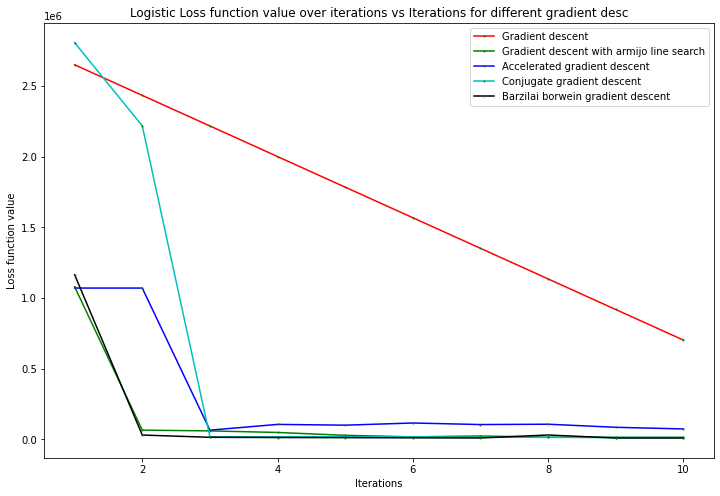

In [39]:
from matplotlib import pyplot as plt

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)

plt.xlabel('Iterations')
plt.ylabel('Loss function value')
plt.title('Logistic Loss function value over iterations vs Iterations for different gradient desc')
plt.plot(X_, funV1, '-r', label='Gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.plot(X_, funV2, '-g', label='Gradient descent with armijo line search', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.plot(X_, funV3, '-b', label='Accelerated gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.plot(X_, funV4, '-c', label='Conjugate gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.plot(X_, funV5, '-k', label='Barzilai borwein gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.legend(loc="upper right")
plt.show()

In [40]:
"""
Running gradient descent techniques for hinge loss
"""

X = loadmat(r"train.mat")
y = np.loadtxt(r"train.targets")
X = X['X'].todense()
w = np.random.random(X.shape[1])
y = np.array(y)
X_main = X
Y_main = y

num_iterations = 250
gamma = 0.0001
verbosity = 1
gd_alpha = 0.00001
gd_with_ls_alpha = 0
lam = 0.01

print("Running gradient descent algorithms for hinge loss")
print("Running normal gradient descent")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funH1 = gd(hingeLoss, w, num_iterations, gd_alpha, X, y, lam, verbosity)

print("Running gradient descent with armijo line search v4")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funH2 = gd_with_line_searchv4(hingeLoss, w, num_iterations, gd_with_ls_alpha, X, y, lam, gamma, verbosity)

print("Running accelerated gradient descent")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funH3 = accelerated_gradient_descent(hingeLoss, w, num_iterations, gd_with_ls_alpha, X, y, lam, gamma, verbosity)

print("Running conjugate gradient descent")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funH4 = conjugate_gd(hingeLoss, w, num_iterations, gd_with_ls_alpha, X, y, lam, gamma, verbosity)

print("Running barzilai borwein gradient descent")
w = np.random.random(X.shape[1])
X = X_main
y = Y_main
funH5 = barzilai_borwein(hingeLoss, w, num_iterations, gd_with_ls_alpha, X, y, lam, gamma, verbosity)

X_ = []
for i in range(num_iterations):
  X_.append(i+1)


Running gradient descent algorithms for hinge loss
Running normal gradient descent
1 1e-05 2718467.3702332103 12225.005721932892
2 1e-05 2501967.6713966355 12225.003276931746
3 1e-05 2285468.059159931 12225.000831931091
4 1e-05 2068968.5335230615 12224.998386930925
5 1e-05 1852469.0944859937 12224.995941931247
6 1e-05 1635969.742048693 12224.993496932058
7 1e-05 1419470.4762111253 12224.99105193336
8 1e-05 1202971.2969732548 12224.988606935149
9 1e-05 986472.2043350475 12224.986161937428
10 1e-05 769985.6772481838 12216.983716940196
Running gradient descent with armijo line search v4
2 8.179955368482221e-05 1070105.3497918474 12224.985577084812
3 0.00016359897354630476 60649.567107286166 452.0595514411918
4 9.325267069159991e-05 55180.27482500543 452.05870832598214
5 0.00018650516746198835 44288.405003380896 446.0570221002801
6 0.00037141872796969585 25619.585641352205 343.0537086216451
7 0.0006565842023317125 17473.583050436475 342.0187937429366
8 0.0005187864919126373 20658.542146784

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:303: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


2 8.179960729823043e-05 28414.39359123985 1044.9749967362252
3 9.028045247774945e-05 14522.333159893482 300.00280015952467
4 0.00012038769260485664 12610.796660488397 198.99666193899856
5 0.0002305906759277172 11447.547589749009 124.02862524937974
6 0.0005308589507335086 10313.551450739904 95.99442771848962
7 0.0009393752614161984 10014.356106115076 181.04223133772481
8 0.0005975195303826834 14273.997997224847 620.9837481442902
9 0.00018754769320148738 9138.47600072416 66.0050329920411
10 0.0019627413893582614 8041.502263690358 60.02500761383855


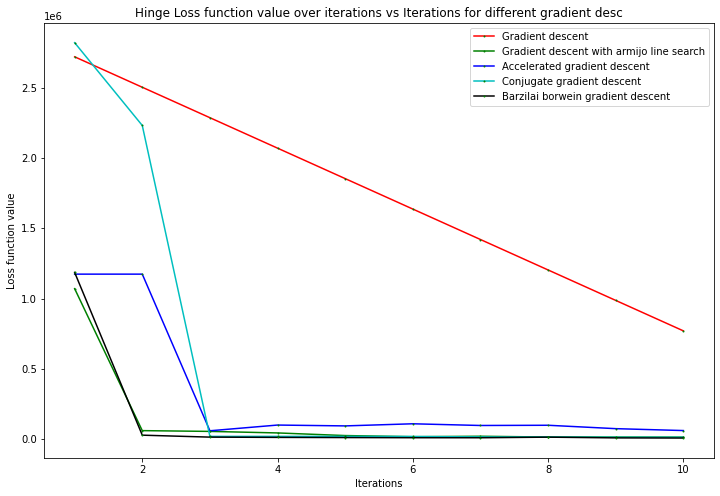

In [41]:
from matplotlib import pyplot as plt

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)


plt.xlabel('Iterations')
plt.ylabel('Loss function value')
plt.title('Hinge Loss function value over iterations vs Iterations for different gradient desc')
plt.plot(X_, funH1, '-r', label='Gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.plot(X_, funH2, '-g', label='Gradient descent with armijo line search', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.plot(X_, funH3, '-b', label='Accelerated gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.plot(X_, funH4, '-c', label='Conjugate gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.plot(X_, funH5, '-k', label='Barzilai borwein gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.legend(loc="upper right")
plt.show()

In [42]:
"""
Q5. Compare gradient descent and proximal gradient descent.

Proximal gradient descent works better than normal gradient descent by calculating the prox operator. 
It is evident from the plot that proximal gradient descent works better.
"""
from scipy.io import loadmat
import math
import pandas as pd
import numpy as np

def logisticLossL1(w, X, y, lam):
    m = X.shape[0]
    Xw = np.matmul(X, w)

    loss = np.sum(np.log(1 + np.exp(-1 * y * (Xw))))
    loss += lam * (np.linalg.norm(w))

    grad = np.zeros(w.shape)
    nexp = np.exp(-1 * y * (Xw))
    grad = (-1) * np.matmul(X.T, y * nexp / (1 + nexp))
    grad += w
    return loss, grad

def logisticLoss(w, X, y, lam):
    m = X.shape[0]
    Xw = np.matmul(X, w)

    loss = np.sum(np.log(1 + np.exp(-1 * y * (Xw))))
    #loss += lam * (np.linalg.norm(w))

    grad = np.zeros(w.shape)
    nexp = np.exp(-1 * y * (Xw))
    grad = (-1) * np.matmul(X.T, y * nexp / (1 + nexp))
    #grad += w
    return loss, grad

def gd(funObj, w, maxEvals, alpha, X, y, lam, verbosity):
    [f,g] = funObj(np.array(w), np.array(X), np.array(y), lam)
    funEvals = 1
    funVals = []

    while (1):
        w = w - alpha*g
        [f,g] = funObj(np.array(w), np.array(X), np.array(y), lam)
        optCond = np.linalg.norm(g, np.inf)

        if verbosity > 0:
            print(funEvals, alpha, f, optCond)

        
        funEvals = funEvals + 1
        funVals.append(f)
        if (optCond < 0.001) or (funEvals > maxEvals):
            break
        

    return funVals

def proxNorm1(y, lamda):
    return np.sign(y)*np.maximum(np.zeros(np.shape(y)), np.abs(y)-lamda)
    #return np.sign(y)*(np.abs(y)-lamda).astype(int)
    

def proximal_gd(funObj, w, maxEvals, alpha, X, y, lam, verbosity):
    [f,g] = funObj(np.array(w), np.array(X), np.array(y), lam)
    funEvals = 1
    funVals = []
    lam_np = np.ones(w.shape)
    lam_np = lam_np * lam

    while (1):
        wk = w - alpha * g
        wk = proxNorm1(np.array(wk), lam*alpha)
        [f,g] = funObj(np.array(w), np.array(X), np.array(y), lam)
        w = wk
        optCond = np.linalg.norm(g, np.inf)

        if verbosity > 0:
            print(funEvals, alpha, f, optCond)

        
        funEvals = funEvals + 1
        funVals.append(f)
        if (optCond < 0.001) or (funEvals > maxEvals):
            break
        

    return funVals

X = loadmat(r"train.mat")
y = np.loadtxt(r"train.targets")

X = X['X'].todense()
w = np.random.random(X.shape[1])
y = np.array(y)

num_iterations = 250
gamma = 0.0001
verbosity = 1
gd_alpha = 0.00001
gd_with_ls_alpha = 0
lam = 1000
results_p = []

print("Running normal gradient descent")
w = np.random.random(X.shape[1])
funV = gd(logisticLossL1, w, num_iterations, gd_alpha, X, y, lam, verbosity)
results_p.append(funV)

print("Running proximal gradient descent")
w = np.random.random(X.shape[1])
funV = proximal_gd(logisticLoss, w, num_iterations, gd_alpha, X, y, lam, verbosity)
results_p.append(funV)

X_ = []
for i in range(num_iterations):
  X_.append(i+1)

Running normal gradient descent
1 1e-05 2723906.577289793 12225.823185032847
2 1e-05 2506725.0462064305 12225.700926800997
3 1e-05 2289590.956626279 12225.578669791728
4 1e-05 2072506.5023357752 12225.45641400503
5 1e-05 1855473.8338299845 12225.33415944089
6 1e-05 1638495.026653045 12225.211906099295
7 1e-05 1421572.0472481423 12225.089653980234
8 1e-05 1204706.7172613174 12224.967403081304
9 1e-05 987900.6793818977 12224.843277771019
10 1e-05 771238.0226202043 12198.128805712218
Running proximal gradient descent
1 1e-05 2870967.704009099 12225.0
2 1e-05 2601377.4920202466 12225.0
3 1e-05 2337463.3537439844 12225.0
4 1e-05 2077577.5470824246 12225.0
5 1e-05 1822790.1176313893 12225.0
6 1e-05 1573605.0970123678 12225.0
7 1e-05 1330016.9384190468 12225.0
8 1e-05 1091995.3154273033 12224.99999999966
9 1e-05 859160.5400199131 12224.999871593693
10 1e-05 631552.871489963 12207.09949487999


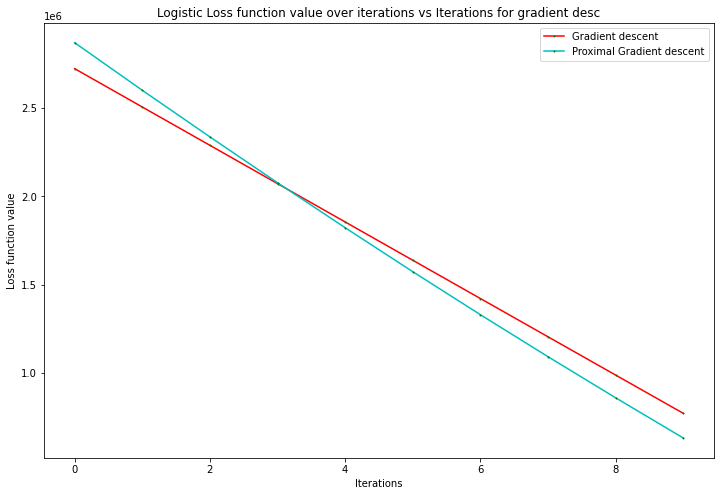

In [43]:
from matplotlib import pyplot as plt
import numpy as np

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)
Xn = np.arange(num_iterations)
plt.xlabel('Iterations')
plt.ylabel('Loss function value')
plt.title('Logistic Loss function value over iterations vs Iterations for gradient desc')
plt.plot(Xn, results_p[0], '-r', label='Gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.plot(Xn, results_p[1], '-c', label='Proximal Gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.legend(loc="upper right")
plt.show()

In [44]:
"""
from matplotlib import pyplot as plt

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)


plt.xlabel('Iterations')
plt.ylabel('Loss function value')
plt.title('Logistic Loss function value over iterations vs Iterations for barzilai borwein gradient desc')
plt.plot(X_, funV5, '-b', label='Barzilai borwein gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.legend(loc="upper right")
plt.show()
"""

'\nfrom matplotlib import pyplot as plt\n\nF = plt.gcf()\nSize = F.get_size_inches()\nF.set_size_inches(Size[0]*2, Size[1]*2, forward=True)\n\n\nplt.xlabel(\'Iterations\')\nplt.ylabel(\'Loss function value\')\nplt.title(\'Logistic Loss function value over iterations vs Iterations for barzilai borwein gradient desc\')\nplt.plot(X_, funV5, \'-b\', label=\'Barzilai borwein gradient descent\', marker=\'o\', markerfacecolor =\'g\', markeredgecolor =\'g\', markersize=1)\nplt.legend(loc="upper right")\nplt.show()\n'

In [45]:
"""
from matplotlib import pyplot as plt



F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)

plt.legend(loc="upper left")
plt.xlabel('Iterations')
plt.ylabel('Loss function value')
plt.title('Hinge Loss function value over iterations vs Iterations for gradient desc')
plt.plot(X_, results2[0], '-r', label='Gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.show()
plt.clf()

plt.legend(loc="upper left")
plt.xlabel('Iterations')
plt.ylabel('Loss function value')
plt.title('Hinge Loss function value over iterations vs Iterations for Gradient descent with armijo')
plt.plot(X_, results2[1], '-b', label='Gradient descent with armijo line search', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.show()
plt.clf()

plt.legend(loc="upper left")
plt.xlabel('Iterations')
plt.ylabel('Loss function value')
plt.title('Hinge Loss function value over iterations vs Iterations for Accelerated Gradient descent')
plt.plot(X_, results3[2], '-c', label='Accelerated Gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.show()
plt.clf()

plt.legend(loc="upper left")
plt.xlabel('Iterations')
plt.ylabel('Loss function value')
plt.title('Hinge Loss function value over iterations vs Iterations for Conjugate Gradient descent')
plt.plot(X_, results3[3], '-m', label='Conjugate Gradient descent', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.show()
plt.clf()

plt.legend(loc="upper left")
plt.xlabel('Iterations')
plt.ylabel('Loss function value')
plt.title('Hinge Loss function value over iterations vs Iterations for Barzilai Borwein')
plt.plot(X_, results2[4], '-k', label='Barzilai Borwein', marker='o', markerfacecolor ='g', markeredgecolor ='g', markersize=1)
plt.show()
"""

'\nfrom matplotlib import pyplot as plt\n\n\n\nF = plt.gcf()\nSize = F.get_size_inches()\nF.set_size_inches(Size[0]*2, Size[1]*2, forward=True)\n\nplt.legend(loc="upper left")\nplt.xlabel(\'Iterations\')\nplt.ylabel(\'Loss function value\')\nplt.title(\'Hinge Loss function value over iterations vs Iterations for gradient desc\')\nplt.plot(X_, results2[0], \'-r\', label=\'Gradient descent\', marker=\'o\', markerfacecolor =\'g\', markeredgecolor =\'g\', markersize=1)\nplt.show()\nplt.clf()\n\nplt.legend(loc="upper left")\nplt.xlabel(\'Iterations\')\nplt.ylabel(\'Loss function value\')\nplt.title(\'Hinge Loss function value over iterations vs Iterations for Gradient descent with armijo\')\nplt.plot(X_, results2[1], \'-b\', label=\'Gradient descent with armijo line search\', marker=\'o\', markerfacecolor =\'g\', markeredgecolor =\'g\', markersize=1)\nplt.show()\nplt.clf()\n\nplt.legend(loc="upper left")\nplt.xlabel(\'Iterations\')\nplt.ylabel(\'Loss function value\')\nplt.title(\'Hinge Los